In [66]:
import scipy as sp
import scipy.io.wavfile as wavfile
import os
import gmmhmm as hmm
import MFCC
import numpy as np
import re
import random
import pickle
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import time

## Problem 1

Write a function which accepts a GMMHMM as well as
an integer n_sim, and which simulates the GMMHMM process, generating n_sim different
observations. Use the example GMMHMM to sample 900 times. Use PCA from SkLearn to plot your generated observations in 2D space. Color observations by state.

In [7]:
def sample_gmmhmm(gmmhmm, n_sim):
    """
    Simulate from a GMMHMM.
    
    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, M)
        The generated observations (vectors of length M)
    """    
    states = []
    obs = []
    state = np.argmax(np.random.multinomial(1,gmmhmm[-1]))
    for i in range(n_sim):
        sample_component = np.argmax(np.random.multinomial(1, gmmhmm[1][state,:]))
        sample = np.random.multivariate_normal(gmmhmm[2][state, sample_component, :], gmmhmm[3][state, sample_component, :, :])
        states.append(state)
        obs.append(sample)
        state = np.argmax(np.random.multinomial(1, gmmhmm[0][:,state]))
    return np.array(states), np.array(obs)
    
    
A = np.array([[.65, .35], [.15, .85]]) # state transition matrix
pi = np.array([.8, .2]) # initial state distribution
weights = np.array([[.7, .2, .1], [.1, .5, .4]])
means1 = np.array([[0., 17., -4.], [5., -12., -8.], [-16., 22., 2.]])
means2 = np.array([[-5., 3., 23.], [-12., -2., 14.], [15., -32., 0.]])
means = np.array([means1, means2])
covars1 = np.array([5*np.eye(3), 7*np.eye(3), np.eye(3)])
covars2 = np.array([10*np.eye(3), 3*np.eye(3), 4*np.eye(3)])
covars = np.array([covars1, covars2])
gmmhmm = [A, weights, means, covars, pi]

states, samples = sample_gmmhmm(gmmhmm, 900)

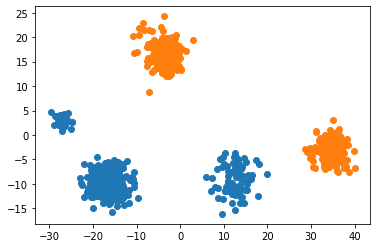

In [26]:
ys = PCA(n_components=2).fit_transform(samples)
ys_0 = ys[states == 0]
ys_1 = ys[states == 1]
plt.scatter(ys_0[:,0], ys_0[:,1])
plt.scatter(ys_1[:,0], ys_1[:,1])
plt.show()

## Problem 2

Samples.zip contains 30 recordings for each of the words/phrases mathematics, biology, political science, psychology, and statistics. These audio samples are 2 seconds in
duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed
integers in WAV format. 
Load the recordings into Python using scipy.io.wavfile.read

Extract the MFCCs from each sample using code from the file MFCC.py.
Store the MFCCs for each word in a separate list. You should have five lists, each containing
30 MFCC arrays, corresponding to each of the five words under consideration.

<ipython-input-43-1d38d18fb8de>:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  lists[i].append(MFCC.extract(wavfile.read("Samples/" + f)[1]))


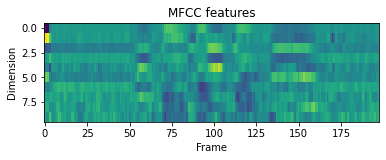

In [43]:
lists = [[] for i in range(5)]
topics = ["Biology", "Mathematics", "Psychology", "Statistics", "PoliticalScience"]
for f in os.listdir("Samples"):
    for i, t in enumerate(topics):
        if t in f:
            lists[i].append(MFCC.extract(wavfile.read("Samples/" + f)[1]))

## Problem 3

Partition each list of MFCCs into a training set of 20 samples, and a test set of
the remaining 10 samples.
Using the training sets, train a GMMHMM on each of the words from the previous problem
with at least 10 random restarts, keeping the best model for each word (the one with the highest
log-likelihood). This process may take several minutes. Since you will not want to run this
more than once, you will want to save the best model for each word to disk using the pickle
module so that you can use it later.

In [28]:
def initialize(n_states):
    transmat = np.ones((n_states,n_states))/float(n_states)
    for i in range(n_states):
        transmat[i,:] += sp.random.uniform(-1./n_states,1./n_states,n_states)
        transmat[i,:] /= sum(transmat[i,:])
    startprob = np.ones(n_states)/float(n_states) + sp.random.uniform(-1./n_states,1./n_states,n_states)
    startprob /= sum(startprob)
    return startprob, transmat

In [100]:
# Do train test split
train_dict_list = []
test_dict_list = []
for l, topic in zip(lists, topics):
    shuffled = np.random.permutation(30)
    train = shuffled[:20]
    test = shuffled[20:]
    train_dict_list.append((topic, np.array(l)[train]))
    test_dict_list.append((topic, np.array(l)[test]))
                          
train_dict = dict(train_dict_list)
test_dict = dict(test_dict_list)

In [91]:
model_dict_list = []
for topic, samples in train_dict.items():
    logprobs = []
    models = []
    # 10 random restarts
    for i in range(10):
        startprob, transmat = initialize(5)
        model = hmm.GMMHMM(n_components=5, 
                           n_mix=3, 
                           transmat=transmat, 
                           startprob=startprob, 
                           cvtype='diag')
        # these values for covars_prior and var should work well for this problem
        model.covars_prior = 0.01
        model.fit(samples, init_params='mc', var=0.1)
        
        logprobs.append(model.logprob)
        models.append(model)
    model_dict_list.append((topic, models[np.argmax(logprobs)]))

## Problem 4

Classify the 10 test samples for each word. Make a dictionary containing the accuracy
of the classification of your five testing sets where the words/phrases are the keys,
and the values are the percent accuracy.

Write a few sentences answering the following questions:
How does your system perform?
Which words are the hardest to correctly classify?

In [108]:
# model_dict = dict(model_dict_list)

topic_scores = []
# Look at the 10 test samples for each topic
for topic, samples in test_dict.items():
    topic_score = 0
    # For each sample
    for sample in samples:
        model_scores = []
        # See which model gives it the best score
        for model in model_dict.values():
            model_scores.append(model.score(sample))
        # See if the best score is the right topic
        if topics[np.argmax(model_scores)] == topic:
            topic_score += 1
    print("{}: {}".format(topic, topic_score / 10))
    topic_scores.append(topic_score / 10)
print()
print(dict([(t, s) for t, s in zip(topics, topic_scores)]))

Biology: 1.0
Mathematics: 1.0
Psychology: 1.0
Statistics: 1.0
PoliticalScience: 0.9

{'Biology': 1.0, 'Mathematics': 1.0, 'Psychology': 1.0, 'Statistics': 1.0, 'PoliticalScience': 0.9}


Mine seems to have done a really great job, Political science was less accurate, that could be because it is such a different word than the other words that it may have had a hard time recognizing it. It's way longer and has 2 words in it so I think that could be the cause. 